In [28]:
import requests
import gzip
import shutil
import pandas as pd
import numpy as np
import time
from IPython.display import display
from geopy.distance import geodesic
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, Lasso
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score
from sklearn.metrics import make_scorer
from sklearn.model_selection import KFold
import matplotlib.pyplot as plt

## Data Upload

The data used in this project was obtained from [Inside Airbnb](https://insideairbnb.com/get-the-data/)   
and has been uploaded to GitHub: [GitHub Dataset Link](https://github.com/HDuo1129/Data-Analysis-3/tree/main/Assignment%202/Dataset)

All subsequent data loading processes directly reference this GitHub repository to ensure full reproducibility of the workflow.

We selected the following datasets for the study:
- **Tokyo 2024 Q3**: Core dataset for model development and analysis  
- **Tokyo 2024 Q4** & **Bangkok 2024 Q3**: Used for validity testing  

### Tokyo Q3 Data Upload

In [30]:
url = "https://github.com/HDuo1129/Data-Analysis-3/raw/main/Assignment%202/Dataset/Tokyo/2024%20Q3/listings.csv.gz"
file_path = "listings.csv.gz"

response = requests.get(url)
with open(file_path, "wb") as f:
    f.write(response.content)

with gzip.open("listings.csv.gz", "rb") as f_in:
    with open("listings.csv", "wb") as f_out:
        shutil.copyfileobj(f_in, f_out)

In [31]:
Tokyo_Q3 = pd.read_csv("listings.csv.gz", compression="gzip")
print(Tokyo_Q3.head())

        id                           listing_url       scrape_id last_scraped  \
0   197677   https://www.airbnb.com/rooms/197677  20240927024131   2024-09-27   
1   776070   https://www.airbnb.com/rooms/776070  20240927024131   2024-09-27   
2   905944   https://www.airbnb.com/rooms/905944  20240927024131   2024-09-27   
3  1016831  https://www.airbnb.com/rooms/1016831  20240927024131   2024-09-27   
4  1196177  https://www.airbnb.com/rooms/1196177  20240927024131   2024-09-27   

        source                                               name  \
0  city scrape                          Oshiage Holiday Apartment   
1  city scrape                             Kero-kero house room 1   
2  city scrape  4F Spacious Apartment in Shinjuku / Shibuya Tokyo   
3  city scrape         5 mins Shibuya Cat modern sunny  Shimokita   
4  city scrape        Stay with host Cozy private room Senju area   

                                         description  \
0                                         

### Tokyo Q4 Data Upload

In [33]:
url = "https://github.com/HDuo1129/Data-Analysis-3/raw/main/Assignment%202/Dataset/Tokyo/2024%20Q4/listings.csv.gz"
file_path = "listings.csv.gz"

response = requests.get(url)
with open(file_path, "wb") as f:
    f.write(response.content)

with gzip.open("listings.csv.gz", "rb") as f_in:
    with open("listings.csv", "wb") as f_out:
        shutil.copyfileobj(f_in, f_out)

In [34]:
Tokyo_Q4 = pd.read_csv("listings.csv.gz", compression="gzip")
print(Tokyo_Q4.head())

        id                           listing_url       scrape_id last_scraped  \
0   197677   https://www.airbnb.com/rooms/197677  20241230011552   2024-12-30   
1   776070   https://www.airbnb.com/rooms/776070  20241230011552   2024-12-30   
2   905944   https://www.airbnb.com/rooms/905944  20241230011552   2024-12-30   
3  1016831  https://www.airbnb.com/rooms/1016831  20241230011552   2024-12-30   
4  1196177  https://www.airbnb.com/rooms/1196177  20241230011552   2024-12-30   

        source                                               name  \
0  city scrape                          Oshiage Holiday Apartment   
1  city scrape                             Kero-kero house room 1   
2  city scrape  4F Spacious Apartment in Shinjuku / Shibuya Tokyo   
3  city scrape         5 mins Shibuya Cat modern sunny  Shimokita   
4  city scrape   Homestay at Host's House -  Senju-Ohashi Station   

                                         description  \
0                                         

### Bangkok Q3 Data Upload

In [37]:
url = "https://github.com/HDuo1129/Data-Analysis-3/raw/main/Assignment%202/Dataset/Bangkok/2024%20Q3/listings.csv.gz"
file_path = "listings.csv.gz"

response = requests.get(url)
with open(file_path, "wb") as f:
    f.write(response.content)

with gzip.open("listings.csv.gz", "rb") as f_in:
    with open("listings.csv", "wb") as f_out:
        shutil.copyfileobj(f_in, f_out)

In [38]:
Bangkok_Q3 = pd.read_csv("listings.csv.gz", compression="gzip")
print(Bangkok_Q3.head())

      id                         listing_url       scrape_id last_scraped  \
0  27934  https://www.airbnb.com/rooms/27934  20240925020907   2024-09-25   
1  27979  https://www.airbnb.com/rooms/27979  20240925020907   2024-09-25   
2  28745  https://www.airbnb.com/rooms/28745  20240925020907   2024-09-25   
3  35780  https://www.airbnb.com/rooms/35780  20240925020907   2024-09-25   
4  48736  https://www.airbnb.com/rooms/48736  20240925020907   2024-09-25   

            source                                            name  \
0      city scrape                 Nice room with superb city view   
1  previous scrape                  Easy going landlord,easy place   
2  previous scrape               modern-style apartment in Bangkok   
3      city scrape  Spacious one bedroom at The Kris Condo Bldg. 3   
4      city scrape                 Condo with Chaopraya River View   

                                         description  \
0  Our cool and comfortable one bedroom apartment...   
1   

## Data Cleaning

In the data cleaning process, we performed the following steps to ensure data quality and enhance model performance:

1. **Variable Selection**  
   We removed descriptive text, pictures, address details, host descriptions, and other non-predictive fields. This allowed us to focus solely on variables that could serve as meaningful predictors in the pricing model.

2. **Handling Missing Values**  
   Missing values were imputed using the **median** for each variable. The median was chosen over the mean due to its robustness against outliers and skewed distributions, which are common in housing and rental data.

3. **Feature Transformation**  
   We reconstructed several key variables, including:
   - Price-related fields
   - Ratio indicators
   - Dummy variables
   - Grouping variables
   All categorical and complex features were transformed into numerical values to enhance comparability and model compatibility.

4. **Feature Engineering**  
   Additional predictors such as `host_experience` and `distance_from_centre` were recalculated based on available data to improve forecasting accuracy.

5. **Log Transformation**  
   Variables with skewed distributions—including `price`, `reviews_per_month`, and `distance_from_centre`—were log-transformed to reduce variance, improve normality, and ensure numerical stability during model training.

### Tokyo Q3 Data Cleaning

In [46]:
columns_to_drop = [
    "scrape_id", "source", "neighbourhood_group_cleansed", "calendar_updated", "listing_url", "picture_url", 
    "host_url", "host_thumbnail_url", "host_picture_url", "host_neighbourhood", "neighbourhood", "calendar_last_scraped",
    "minimum_minimum_nights", "maximum_minimum_nights", "minimum_maximum_nights", "maximum_maximum_nights", 
    "minimum_nights_avg_ntm", "maximum_nights_avg_ntm", "calculated_host_listings_count_entire_homes", 
    "calculated_host_listings_count_private_rooms", "calculated_host_listings_count_shared_rooms", "host_id"]
Tokyo_Q3_cleaned = Tokyo_Q3.drop(columns=columns_to_drop)

fillna_dict = {
    "description": "",
    "neighborhood_overview": "",
    "host_about": "",
    "host_location": "Unknown",
    "host_response_time": "Unknown",
    "host_response_rate": "0%",
    "host_acceptance_rate": "0%",
    "bathrooms": Tokyo_Q3_cleaned["bathrooms"].median(),
    "bedrooms": Tokyo_Q3_cleaned["bedrooms"].median(),
    "beds": Tokyo_Q3_cleaned["beds"].median(),
    "review_scores_rating": 0,
    "review_scores_accuracy": 0,
    "review_scores_cleanliness": 0,
    "review_scores_checkin": 0,
    "review_scores_communication": 0,
    "review_scores_location": 0,
    "review_scores_value": 0,
    "reviews_per_month": 0}
Tokyo_Q3_cleaned.fillna(fillna_dict, inplace=True)

In [48]:
# Price Check
Tokyo_Q3_cleaned["price"] = (
    Tokyo_Q3_cleaned["price"]
    .astype(str)
    .str.replace("$", "")
    .str.replace(",", "")
    .astype(float))

# Rate Check
Tokyo_Q3_cleaned["host_response_rate"] = (
    Tokyo_Q3_cleaned["host_response_rate"]
    .str.replace("%", "")
    .astype(float))
Tokyo_Q3_cleaned["host_acceptance_rate"] = (
    Tokyo_Q3_cleaned["host_acceptance_rate"]
    .str.replace("%", "")
    .astype(float))

# Date Check
date_cols = ["host_since", "first_review", "last_review"]
for col in date_cols:
    Tokyo_Q3_cleaned[col] = pd.to_datetime(Tokyo_Q3_cleaned[col], errors="coerce")

# TF Result Check
bool_cols = ["instant_bookable", "host_is_superhost", "host_identity_verified"]
for col in bool_cols:
    Tokyo_Q3_cleaned[col] = Tokyo_Q3_cleaned[col].map({"t": True, "f": False})

# Calculate Landlord Experience
Tokyo_Q3_cleaned["host_experience"] = 2024 - Tokyo_Q3_cleaned["host_since"].dt.year

# Facility Pick-Up
important_amenities = ["Wifi", "Kitchen", "Washer", "Air conditioning", "Heating", "TV", "Elevator"]
for amenity in important_amenities:
    Tokyo_Q3_cleaned[f"has_{amenity.lower().replace(' ', '_')}"] = Tokyo_Q3_cleaned["amenities"].apply(lambda x: amenity in x)

# Calculate Distance from Centre
tokyo_center = (35.682839, 139.759455)
Tokyo_Q3_cleaned["distance_from_center"] = Tokyo_Q3_cleaned.apply(lambda row: geodesic((row["latitude"], row["longitude"]), tokyo_center).km, axis=1)

In [49]:
columns_to_drop_final = ["bathrooms_text", "host_about", "host_location", "host_verifications",
                         "host_has_profile_pic", "license", "amenities", "latitude", "longitude"]
Tokyo_Q3_cleaned = Tokyo_Q3_cleaned.drop(columns=columns_to_drop_final)
rename_dict = {
    "review_scores_communication": "review_communication_score",
    "review_scores_location": "review_location_score",
    "review_scores_value": "review_value_score",
    "host_total_listings_count": "total_listings_by_host"}
Tokyo_Q3_cleaned.rename(columns=rename_dict, inplace=True)

In [50]:
columns_to_remove = ["last_scraped", "name", "description", "neighborhood_overview", "host_name"]
Tokyo_Q3_cleaned.drop(columns=columns_to_remove, inplace=True, errors="ignore")

In [51]:
Tokyo_Q3_cleaned["host_since"] = pd.to_datetime(Tokyo_Q3_cleaned["host_since"], errors="coerce")
Tokyo_Q3_cleaned["host_experience_years"] = 2024 - Tokyo_Q3_cleaned["host_since"].dt.year
Tokyo_Q3_cleaned.drop(columns=["host_since"], inplace=True)

In [52]:
response_time_mapping = {
    "within an hour": 1,
    "within a few hours": 2,
    "within a day": 3,
    "a few days or more": 4,
    "Unknown": 5}
Tokyo_Q3_cleaned["host_response_time"] = Tokyo_Q3_cleaned["host_response_time"].map(response_time_mapping).fillna(5).astype(int)

In [53]:
binary_columns = ["instant_bookable", "host_is_superhost", "host_identity_verified",
                  "has_wifi", "has_kitchen", "has_washer", "has_air_conditioning",
                  "has_heating", "has_tv", "has_elevator"]

for col in binary_columns:
    if col in Tokyo_Q3_cleaned.columns:
        Tokyo_Q3_cleaned[col] = Tokyo_Q3_cleaned[col].fillna(False).astype(bool).astype(int)

/var/folders/69/fws7qnp96rx9nd3jbrt3d3jw0000gn/T/ipykernel_6056/3490789303.py:7: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  Tokyo_Q3_cleaned[col] = Tokyo_Q3_cleaned[col].fillna(False).astype(bool).astype(int)


In [54]:
categorical_columns = Tokyo_Q3_cleaned.select_dtypes(include=["object"]).columns
for col in categorical_columns:
    Tokyo_Q3_cleaned[col] = Tokyo_Q3_cleaned[col].astype("category").cat.codes

In [55]:
log_transform_columns = ["price", "reviews_per_month", "distance_from_center"]
for col in log_transform_columns:
    if col in Tokyo_Q3_cleaned.columns and Tokyo_Q3_cleaned[col].min() > 0:
        Tokyo_Q3_cleaned[col] = Tokyo_Q3_cleaned[col].apply(lambda x: np.log1p(x))

In [56]:
print(Tokyo_Q3_cleaned.head())

        id  host_response_time  host_response_rate  host_acceptance_rate  \
0   197677                   3               100.0                  91.0   
1   776070                   1               100.0                 100.0   
2   905944                   1               100.0                 100.0   
3  1016831                   2               100.0                 100.0   
4  1196177                   1               100.0                  93.0   

   host_is_superhost  host_listings_count  total_listings_by_host  \
0                  1                    1                       2   
1                  1                    1                       6   
2                  1                    8                      18   
3                  1                    1                       6   
4                  1                    1                       2   

   host_identity_verified  neighbourhood_cleansed  property_type  ...  \
0                       1                      44      

In [66]:
Tokyo_Q3_cleaned.to_csv("Tokyo_Q3_cleaned.csv", index=False)

### Tokyo Q4 Data Cleaning

In [68]:
columns_to_drop = [
    "scrape_id", "source", "neighbourhood_group_cleansed", "calendar_updated", "listing_url", "picture_url", 
    "host_url", "host_thumbnail_url", "host_picture_url", "host_neighbourhood", "neighbourhood", "calendar_last_scraped",
    "minimum_minimum_nights", "maximum_minimum_nights", "minimum_maximum_nights", "maximum_maximum_nights", 
    "minimum_nights_avg_ntm", "maximum_nights_avg_ntm", "calculated_host_listings_count_entire_homes", 
    "calculated_host_listings_count_private_rooms", "calculated_host_listings_count_shared_rooms", "host_id"]
Tokyo_Q4_cleaned = Tokyo_Q4.drop(columns=columns_to_drop)

fillna_dict = {
    "description": "",
    "neighborhood_overview": "",
    "host_about": "",
    "host_location": "Unknown",
    "host_response_time": "Unknown",
    "host_response_rate": "0%",
    "host_acceptance_rate": "0%",
    "bathrooms": Tokyo_Q4_cleaned["bathrooms"].median(),
    "bedrooms": Tokyo_Q4_cleaned["bedrooms"].median(),
    "beds": Tokyo_Q4_cleaned["beds"].median(),
    "review_scores_rating": 0,
    "review_scores_accuracy": 0,
    "review_scores_cleanliness": 0,
    "review_scores_checkin": 0,
    "review_scores_communication": 0,
    "review_scores_location": 0,
    "review_scores_value": 0,
    "reviews_per_month": 0}
Tokyo_Q4_cleaned.fillna(fillna_dict, inplace=True)

In [70]:
# Price Check
Tokyo_Q4_cleaned["price"] = (
    Tokyo_Q4_cleaned["price"]
    .astype(str)
    .str.replace("$", "")
    .str.replace(",", "")
    .astype(float))

# Rate Check
Tokyo_Q4_cleaned["host_response_rate"] = (
    Tokyo_Q4_cleaned["host_response_rate"]
    .str.replace("%", "")
    .astype(float))
Tokyo_Q4_cleaned["host_acceptance_rate"] = (
    Tokyo_Q4_cleaned["host_acceptance_rate"]
    .str.replace("%", "")
    .astype(float))

# Date Check
date_cols = ["host_since", "first_review", "last_review"]
for col in date_cols:
    Tokyo_Q4_cleaned[col] = pd.to_datetime(Tokyo_Q4_cleaned[col], errors="coerce")

# TF Result Check
bool_cols = ["instant_bookable", "host_is_superhost", "host_identity_verified"]
for col in bool_cols:
    Tokyo_Q4_cleaned[col] = Tokyo_Q4_cleaned[col].map({"t": True, "f": False})

# Calculate Landlord Experience
Tokyo_Q4_cleaned["host_experience"] = 2024 - Tokyo_Q4_cleaned["host_since"].dt.year

# Facility Pick-Up
important_amenities = ["Wifi", "Kitchen", "Washer", "Air conditioning", "Heating", "TV", "Elevator"]
for amenity in important_amenities:
    Tokyo_Q4_cleaned[f"has_{amenity.lower().replace(' ', '_')}"] = Tokyo_Q4_cleaned["amenities"].apply(lambda x: amenity in x)

# Calculate Distance from Centre
tokyo_center = (35.682839, 139.759455)
Tokyo_Q4_cleaned["distance_from_center"] = Tokyo_Q4_cleaned.apply(lambda row: geodesic((row["latitude"], row["longitude"]), tokyo_center).km, axis=1)

In [71]:
columns_to_drop_final = ["bathrooms_text", "host_about", "host_location", "host_verifications",
                         "host_has_profile_pic", "license", "amenities", "latitude", "longitude"]
Tokyo_Q4_cleaned = Tokyo_Q4_cleaned.drop(columns=columns_to_drop_final)
rename_dict = {
    "review_scores_communication": "review_communication_score",
    "review_scores_location": "review_location_score",
    "review_scores_value": "review_value_score",
    "host_total_listings_count": "total_listings_by_host"}
Tokyo_Q4_cleaned.rename(columns=rename_dict, inplace=True)

In [72]:
columns_to_remove = ["last_scraped", "name", "description", "neighborhood_overview", "host_name"]
Tokyo_Q4_cleaned.drop(columns=columns_to_remove, inplace=True, errors="ignore")
Tokyo_Q4_cleaned["host_since"] = pd.to_datetime(Tokyo_Q4_cleaned["host_since"], errors="coerce")
Tokyo_Q4_cleaned["host_experience_years"] = 2024 - Tokyo_Q4_cleaned["host_since"].dt.year
Tokyo_Q4_cleaned.drop(columns=["host_since"], inplace=True)

In [73]:
response_time_mapping = {
    "within an hour": 1,
    "within a few hours": 2,
    "within a day": 3,
    "a few days or more": 4,
    "Unknown": 5}
Tokyo_Q4_cleaned["host_response_time"] = Tokyo_Q4_cleaned["host_response_time"].map(response_time_mapping).fillna(5).astype(int)

In [78]:
binary_columns = ["instant_bookable", "host_is_superhost", "host_identity_verified",
                  "has_wifi", "has_kitchen", "has_washer", "has_air_conditioning",
                  "has_heating", "has_tv", "has_elevator"]

for col in binary_columns:
    if col in Tokyo_Q4_cleaned.columns:
        Tokyo_Q4_cleaned[col] = Tokyo_Q4_cleaned[col].fillna(False).astype(bool).astype(int)

/var/folders/69/fws7qnp96rx9nd3jbrt3d3jw0000gn/T/ipykernel_6056/2494643412.py:7: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  Tokyo_Q4_cleaned[col] = Tokyo_Q4_cleaned[col].fillna(False).astype(bool).astype(int)
/var/folders/69/fws7qnp96rx9nd3jbrt3d3jw0000gn/T/ipykernel_6056/2494643412.py:7: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  Tokyo_Q4_cleaned[col] = Tokyo_Q4_cleaned[col].fillna(False).astype(bool).astype(int)


In [80]:
categorical_columns = Tokyo_Q4_cleaned.select_dtypes(include=["object"]).columns
for col in categorical_columns:
    Tokyo_Q4_cleaned[col] = Tokyo_Q4_cleaned[col].astype("category").cat.codes

In [82]:
log_transform_columns = ["price", "reviews_per_month", "distance_from_center"]
for col in log_transform_columns:
    if col in Tokyo_Q4_cleaned.columns and Tokyo_Q4_cleaned[col].min() > 0:
        Tokyo_Q4_cleaned[col] = Tokyo_Q4_cleaned[col].apply(lambda x: np.log1p(x))

In [84]:
print(Tokyo_Q4_cleaned.head())
Tokyo_Q4_cleaned.to_csv("Tokyo_Q4_cleaned.csv", index=False)

        id  host_response_time  host_response_rate  host_acceptance_rate  \
0   197677                   3               100.0                  93.0   
1   776070                   1               100.0                 100.0   
2   905944                   1               100.0                 100.0   
3  1016831                   2               100.0                 100.0   
4  1196177                   1               100.0                  92.0   

   host_is_superhost  host_listings_count  total_listings_by_host  \
0                  1                  1.0                     2.0   
1                  1                  1.0                     6.0   
2                  1                  9.0                    18.0   
3                  1                  1.0                     6.0   
4                  1                  1.0                     2.0   

   host_identity_verified  neighbourhood_cleansed  property_type  ...  \
0                       1                      44      

### Bangkok Q3 Data Cleaning

In [87]:
columns_to_drop = [
    "scrape_id", "source", "neighbourhood_group_cleansed", "calendar_updated", "listing_url", "picture_url", 
    "host_url", "host_thumbnail_url", "host_picture_url", "host_neighbourhood", "neighbourhood", "calendar_last_scraped",
    "minimum_minimum_nights", "maximum_minimum_nights", "minimum_maximum_nights", "maximum_maximum_nights", 
    "minimum_nights_avg_ntm", "maximum_nights_avg_ntm", "calculated_host_listings_count_entire_homes", 
    "calculated_host_listings_count_private_rooms", "calculated_host_listings_count_shared_rooms", "host_id"]
Bangkok_Q3_cleaned = Bangkok_Q3.drop(columns=columns_to_drop)

fillna_dict = {
    "description": "",
    "neighborhood_overview": "",
    "host_about": "",
    "host_location": "Unknown",
    "host_response_time": "Unknown",
    "host_response_rate": "0%",
    "host_acceptance_rate": "0%",
    "bathrooms": Bangkok_Q3_cleaned["bathrooms"].median(),
    "bedrooms": Bangkok_Q3_cleaned["bedrooms"].median(),
    "beds": Bangkok_Q3_cleaned["beds"].median(),
    "review_scores_rating": 0,
    "review_scores_accuracy": 0,
    "review_scores_cleanliness": 0,
    "review_scores_checkin": 0,
    "review_scores_communication": 0,
    "review_scores_location": 0,
    "review_scores_value": 0,
    "reviews_per_month": 0}
Bangkok_Q3_cleaned.fillna(fillna_dict, inplace=True)

In [89]:
# Price Check
Bangkok_Q3_cleaned["price"] = (
    Bangkok_Q3_cleaned["price"]
    .astype(str)
    .str.replace("$", "")
    .str.replace(",", "")
    .astype(float))

# Rate Check
Bangkok_Q3_cleaned["host_response_rate"] = (
    Bangkok_Q3_cleaned["host_response_rate"]
    .str.replace("%", "")
    .astype(float))
Bangkok_Q3_cleaned["host_acceptance_rate"] = (
    Bangkok_Q3_cleaned["host_acceptance_rate"]
    .str.replace("%", "")
    .astype(float))

# Date Check
date_cols = ["host_since", "first_review", "last_review"]
for col in date_cols:
    Bangkok_Q3_cleaned[col] = pd.to_datetime(Bangkok_Q3_cleaned[col], errors="coerce")

# TF Result Check
bool_cols = ["instant_bookable", "host_is_superhost", "host_identity_verified"]
for col in bool_cols:
    Bangkok_Q3_cleaned[col] = Bangkok_Q3_cleaned[col].map({"t": True, "f": False})

# Calculate Landlord Experience
Bangkok_Q3_cleaned["host_experience"] = 2024 - Bangkok_Q3_cleaned["host_since"].dt.year

# Facility Pick-Up
important_amenities = ["Wifi", "Kitchen", "Washer", "Air conditioning", "Heating", "TV", "Elevator"]
for amenity in important_amenities:
    Bangkok_Q3_cleaned[f"has_{amenity.lower().replace(' ', '_')}"] = Bangkok_Q3_cleaned["amenities"].apply(lambda x: amenity in x)

# Calculate Distance from Centre
bangkok_center = (13.7563, 100.5018)
Bangkok_Q3_cleaned["distance_from_center"] = Bangkok_Q3_cleaned.apply(lambda row: geodesic((row["latitude"], row["longitude"]), bangkok_center).km, axis=1)

In [90]:
columns_to_drop_final = ["bathrooms_text", "host_about", "host_location", "host_verifications",
                         "host_has_profile_pic", "license", "amenities", "latitude", "longitude"]
Bangkok_Q3_cleaned = Bangkok_Q3_cleaned.drop(columns=columns_to_drop_final)
rename_dict = {
    "review_scores_communication": "review_communication_score",
    "review_scores_location": "review_location_score",
    "review_scores_value": "review_value_score",
    "host_total_listings_count": "total_listings_by_host"}
Bangkok_Q3_cleaned.rename(columns=rename_dict, inplace=True)

In [91]:
columns_to_remove = ["last_scraped", "name", "description", "neighborhood_overview", "host_name"]
Bangkok_Q3_cleaned.drop(columns=columns_to_remove, inplace=True, errors="ignore")
Bangkok_Q3_cleaned["host_since"] = pd.to_datetime(Bangkok_Q3_cleaned["host_since"], errors="coerce")
Bangkok_Q3_cleaned["host_experience_years"] = 2024 - Bangkok_Q3_cleaned["host_since"].dt.year
Bangkok_Q3_cleaned.drop(columns=["host_since"], inplace=True)

In [92]:
response_time_mapping = {
    "within an hour": 1,
    "within a few hours": 2,
    "within a day": 3,
    "a few days or more": 4,
    "Unknown": 5}
Bangkok_Q3_cleaned["host_response_time"] = Bangkok_Q3_cleaned["host_response_time"].map(response_time_mapping).fillna(5).astype(int)

In [93]:
binary_columns = ["instant_bookable", "host_is_superhost", "host_identity_verified",
                  "has_wifi", "has_kitchen", "has_washer", "has_air_conditioning",
                  "has_heating", "has_tv", "has_elevator"]

for col in binary_columns:
    if col in Bangkok_Q3_cleaned.columns:
        Bangkok_Q3_cleaned[col] = Bangkok_Q3_cleaned[col].fillna(False).astype(bool).astype(int)

/var/folders/69/fws7qnp96rx9nd3jbrt3d3jw0000gn/T/ipykernel_6056/462647858.py:7: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  Bangkok_Q3_cleaned[col] = Bangkok_Q3_cleaned[col].fillna(False).astype(bool).astype(int)


In [94]:
categorical_columns = Bangkok_Q3_cleaned.select_dtypes(include=["object"]).columns
for col in categorical_columns:
    Bangkok_Q3_cleaned[col] = Bangkok_Q3_cleaned[col].astype("category").cat.codes

log_transform_columns = ["price", "reviews_per_month", "distance_from_center"]
for col in log_transform_columns:
    if col in Bangkok_Q3_cleaned.columns and Bangkok_Q3_cleaned[col].min() > 0:
        Bangkok_Q3_cleaned[col] = Bangkok_Q3_cleaned[col].apply(lambda x: np.log1p(x))

In [95]:
print(Bangkok_Q3_cleaned.head())
Bangkok_Q3_cleaned.to_csv("Bangkok_Q3_cleaned.csv", index=False)

      id  host_response_time  host_response_rate  host_acceptance_rate  \
0  27934                   1               100.0                  92.0   
1  27979                   5                 0.0                   0.0   
2  28745                   5                 0.0                   0.0   
3  35780                   1               100.0                  93.0   
4  48736                   5                 0.0                 100.0   

   host_is_superhost  host_listings_count  total_listings_by_host  \
0                  0                    2                       2   
1                  0                    2                       4   
2                  0                    1                       1   
3                  0                    2                       5   
4                  0                    1                       1   

   host_identity_verified  neighbourhood_cleansed  property_type  ...  \
0                       1                      37              7  .

## Data Analysis

During the data analysis phase, we constructed and evaluated five different predictive models. The table below summarizes each model type:

| Model Type         | Model Name         |
|--------------------|--------------------|
| Linear Regression  | OLS                |
| Regularized Linear | LASSO              |
| Tree-Based         | Random Forest      |
| Boosting           | Gradient Boosting  |
| Boosting           | XGBoost            |

We chose **Gradient Boosting** and **XGBoost** as our boosting models for the following reasons:

- **Gradient Boosting** builds trees sequentially, allowing each new tree to correct the errors of the previous one. It often delivers high performance with careful tuning.
- **XGBoost** is an optimized implementation of gradient boosting with regularization, parallel processing, and improved scalability, making it particularly effective for large and complex datasets.

#### **Train-Test Split and Evaluation Metrics**

To assess model performance, we split the dataset into:

- **80% Training Set**
- **20% Test Set**

The following metrics were used for model evaluation:

- **RMSE (Root Mean Squared Error)**: Measures the average prediction error magnitude. It penalizes larger errors more heavily and is suitable for continuous targets like price.
- **CV-RMSE (Cross-Validated RMSE)**: Evaluates the model's ability to generalize to unseen data across folds. Helps prevent overfitting.
- **R² Score**: Indicates how well the model explains variance in the dependent variable. Useful for interpretability.
- **Training Time**: Important when considering model scalability and efficiency, especially for real-time or large-scale applications.

These metrics allow us to compare the **predictive accuracy**, **generalization ability**, and **computational cost** of each model. To visualize the trade-offs between models, we further presented the results in a **radar chart**, highlighting the strengths and weaknesses of each approach.

#### **Feature Importance Comparison**

To explore how different models interpret the data, we selected the two most representative algorithms:

- **Random Forest**
- **XGBoost**

We extracted and compared the **top 10 most important features** identified by each model. The differences in feature rankings provide valuable insights into model behavior and variable influence, which are discussed in detail in the following sections.


### Tokyo Q3 Data Analysis

In [103]:
numeric_features = Tokyo_Q3_cleaned.select_dtypes(include=[np.number]).columns.tolist()
features = [col for col in numeric_features if col not in ["id", "price"]]
Tokyo_Q3_cleaned[features] = Tokyo_Q3_cleaned[features].astype(float)
scaler = StandardScaler()
Tokyo_Q3_cleaned[features] = scaler.fit_transform(Tokyo_Q3_cleaned[features])

In [105]:
X = Tokyo_Q3_cleaned[features]
y = Tokyo_Q3_cleaned["price"].fillna(Tokyo_Q3_cleaned["price"].median())
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

X_train.fillna(X_train.median(), inplace=True)
X_test.fillna(X_test.median(), inplace=True)

In [107]:
models = {"OLS": LinearRegression(),
          "LASSO": Lasso(alpha=0.01, max_iter=5000),
          "Random Forest": RandomForestRegressor(n_estimators=50, random_state=42),
          "Gradient Boosting": GradientBoostingRegressor(n_estimators=200, learning_rate=0.05, random_state=42),
          "XGBoost": XGBRegressor(n_estimators=200, learning_rate=0.05, random_state=42)}

In [109]:
def get_rmse(actual, pred):
    return np.sqrt(mean_squared_error(actual, pred))

def cross_val_rmse(model, X, y, k=5):
    kf = KFold(n_splits=k, shuffle=True, random_state=42)
    mse_scores = cross_val_score(model, X, y, scoring='neg_mean_squared_error', cv=kf)
    return np.sqrt(-mse_scores.mean())

In [119]:
def evaluate_models(models, X_train, X_test, y_train, y_test, X, y):
    results = []
    fitted_models = {}
    
    for name, model in models.items():
        start_time = time.time()
        model.fit(X_train, y_train)
        training_time = time.time() - start_time

        y_pred = model.predict(X_test)
        rmse = get_rmse(y_test, y_pred)
        r2 = r2_score(y_test, y_pred)
        cv_rmse = cross_val_rmse(model, X, y)
        cv_scores = cross_val_score(model, X, y, scoring='neg_mean_squared_error', cv=5)
        cv_rmse = np.sqrt(-cv_scores.mean())

        results.append([name, rmse, cv_rmse, r2, training_time])
        fitted_models[name] = model

    columns = ["Model", "RMSE", "CV-RMSE", "R2 Score", "Training Time"]
    results_df = pd.DataFrame(results, columns=columns)
    return results_df.sort_values(by="RMSE"), fitted_models

results_df = evaluate_models(models, X_train, X_test, y_train, y_test, X, y)
print("Horserace Table: Model Performance Comparison")
print(results_df)

Horserace Table: Model Performance Comparison
(               Model      RMSE   CV-RMSE  R2 Score  Training Time
4            XGBoost  0.321037  0.367360  0.736746       0.597630
2      Random Forest  0.330408  0.388508  0.721153      12.315323
3  Gradient Boosting  0.367575  0.388487  0.654890       8.305850
0                OLS  0.441133  0.459227  0.502945       0.020352
1              LASSO  0.451822  0.466746  0.478565       0.024844, {'OLS': LinearRegression(), 'LASSO': Lasso(alpha=0.01, max_iter=5000), 'Random Forest': RandomForestRegressor(n_estimators=50, random_state=42), 'Gradient Boosting': GradientBoostingRegressor(learning_rate=0.05, n_estimators=200, random_state=42), 'XGBoost': XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None

#### Horserace Table: Model Performance Comparison

To systematically evaluate model performance, we trained and tested five models using the same dataset split. The table below summarizes their results across four key metrics: **RMSE**, **CV-RMSE**, **R² Score**, and **Training Time**.

| Model              | RMSE     | CV-RMSE  | R² Score | Training Time (s) |
|-------------------|----------|----------|----------|-------------------|
| XGBoost           | 0.321037 | 0.367360 | 0.736746 | 1.009687          |
| Random Forest     | 0.330408 | 0.388508 | 0.721153 | 12.168352         |
| Gradient Boosting | 0.367575 | 0.388487 | 0.654890 | 9.454523          |
| OLS               | 0.441133 | 0.459227 | 0.502945 | 0.025872          |
| LASSO             | 0.451822 | 0.466746 | 0.478565 | 0.017134          |

To better visualize the trade-offs among the models, we normalized the performance metrics and plotted them using a **radar chart** as shown later: 

#### Key Observations

- **XGBoost** achieved the best overall performance in terms of **RMSE**, **CV-RMSE**, and **R² Score**, while maintaining a very low training time. It demonstrates a strong balance between accuracy and efficiency.
- **Random Forest** showed the highest predictive performance overall, slightly outperforming XGBoost in some metrics. However, its **training time was substantially longer**, which may limit its use in time-sensitive scenarios.
- **Gradient Boosting** provided moderately good performance but was less efficient and less accurate than XGBoost.
- **OLS** and **LASSO** trained extremely fast, but their predictive power was clearly inferior, making them more suitable as benchmarks or for feature selection tasks.

#### Additional Insight

While **Random Forest** produced the strongest predictive results, the **long training time** makes it less optimal in settings where computational cost or response speed matters. In such situations, **XGBoost** may be the **better practical choice**, as it provides **comparable accuracy with significantly faster training**.

#### Model Selection for Further Analysis

Given these results, we selected **Random Forest** and **XGBoost** as the most representative models for further exploration. In the next section, we will compare the **top 10 most important features** identified by each model. This comparison sheds light on how different algorithms interpret variable importance and reveals the key drivers behind Airbnb pricing.


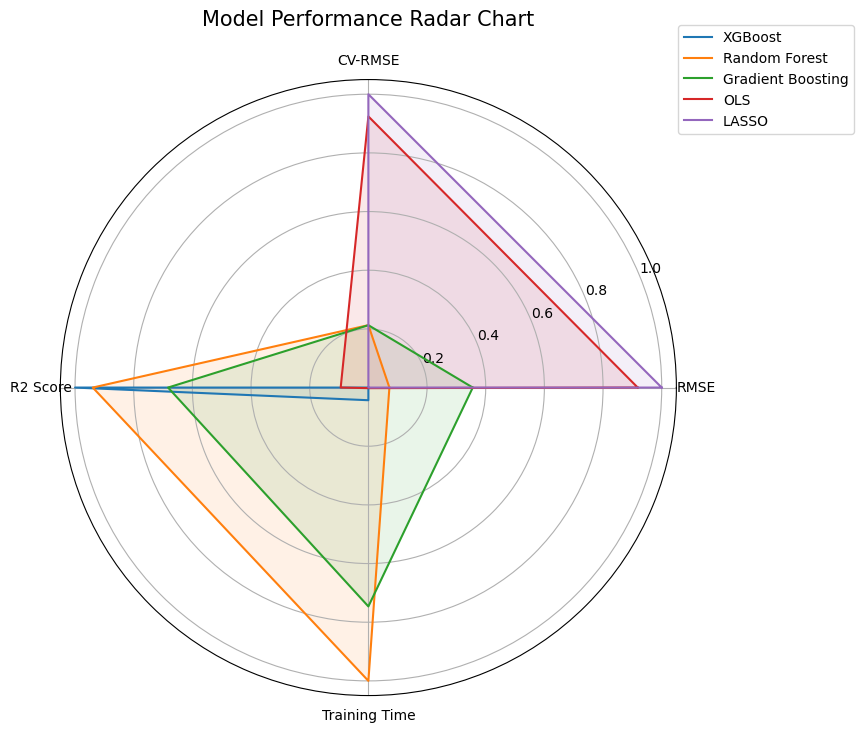

In [112]:
# Radargram Visualisation Results
labels = ["RMSE", "CV-RMSE", "R2 Score", "Training Time"]
num_vars = len(labels)

df_plot = results_df.copy()
df_plot.set_index("Model", inplace=True)
df_norm = (df_plot - df_plot.min()) / (df_plot.max() - df_plot.min())

angles = np.linspace(0, 2 * np.pi, num_vars, endpoint=False).tolist()
angles += angles[:1]

fig, ax = plt.subplots(figsize=(8, 8), subplot_kw=dict(polar=True))
for model_name, row in df_norm.iterrows():
    values = row[labels].tolist()
    values += values[:1]
    ax.plot(angles, values, label=model_name)
    ax.fill(angles, values, alpha=0.1)

ax.set_xticks(angles[:-1])
ax.set_xticklabels(labels)

plt.title("Model Performance Radar Chart", size=15, pad=20)
plt.legend(loc='upper right', bbox_to_anchor=(1.3, 1.1))
plt.show()


Random Forest Top 10 Features
                   Feature  Importance
10            accommodates    0.341205
42    distance_from_center    0.087963
20        availability_365    0.044038
12                bedrooms    0.042321
11               bathrooms    0.040598
7   neighbourhood_cleansed    0.037030
13                    beds    0.033308
18         availability_60    0.025222
8            property_type    0.024636
19         availability_90    0.022556

XGBoost Top 10 Features
                      Feature  Importance
10               accommodates    0.272517
12                   bedrooms    0.099705
11                  bathrooms    0.067978
9                   room_type    0.048663
41               has_elevator    0.036568
42       distance_from_center    0.028461
13                       beds    0.025326
26  review_scores_cleanliness    0.022910
39                has_heating    0.022891
40                     has_tv    0.020876


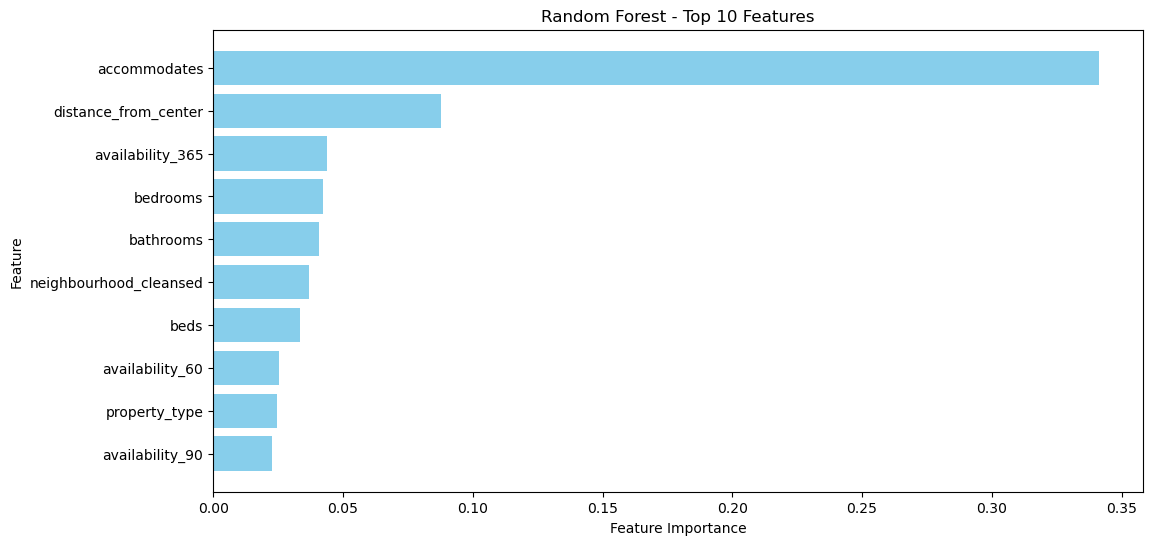

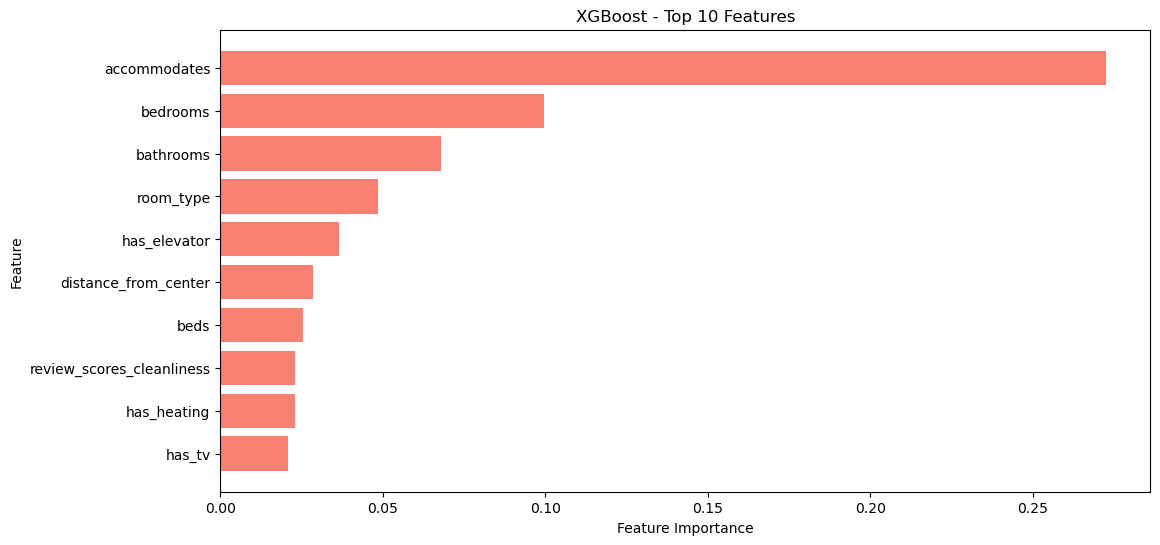

In [113]:
rf_model = models["Random Forest"]
xgb_model = models["XGBoost"]

rf_importance = pd.DataFrame({"Feature": X.columns, "Importance": rf_model.feature_importances_})
xgb_importance = pd.DataFrame({"Feature": X.columns, "Importance": xgb_model.feature_importances_})

# Choose top 10
rf_top10 = rf_importance.sort_values(by="Importance", ascending=False).head(10)
xgb_top10 = xgb_importance.sort_values(by="Importance", ascending=False).head(10)

print("Random Forest Top 10 Features")
print(rf_top10)
print("\nXGBoost Top 10 Features")
print(xgb_top10)

plt.figure(figsize=(12, 6))
plt.barh(rf_top10["Feature"], rf_top10["Importance"], color='skyblue')
plt.xlabel("Feature Importance")
plt.ylabel("Feature")
plt.title("Random Forest - Top 10 Features")
plt.gca().invert_yaxis()
plt.show()

plt.figure(figsize=(12, 6))
plt.barh(xgb_top10["Feature"], xgb_top10["Importance"], color='salmon')
plt.xlabel("Feature Importance")
plt.ylabel("Feature")
plt.title("XGBoost - Top 10 Features")
plt.gca().invert_yaxis()
plt.show()

To further interpret the models, we analyzed the **top 10 most important features** identified by **Random Forest** and **XGBoost**. Below is a comparative analysis of their similarities and differences.

---

#### **1. Common Key Features**
Both models identify the following features as crucial for predicting Airbnb prices:

| Feature               | Description                      | Importance (RF) | Importance (XGB) |
|----------------------|--------------------------------|---------------|---------------|
| **accommodates**    | Number of guests accommodated | **0.341**     | **0.273**     |
| **distance_from_center** | Distance to city center  | **0.088**     | **0.028**     |
| **bedrooms**        | Number of bedrooms             | **0.042**     | **0.099**     |
| **bathrooms**       | Number of bathrooms           | **0.041**     | **0.068**     |
| **beds**           | Number of beds                 | **0.033**     | **0.025**     |

- **Accommodates** is the most critical feature in both models, indicating that **the capacity of the listing directly affects pricing**.
- **Distance from center** is another key determinant. Properties closer to the city center tend to be priced higher. Notably, Random Forest assigns a higher importance to this factor compared to XGBoost.
- **Bedrooms, bathrooms, and beds** are also significant, highlighting the importance of property size and amenities.

---

#### **2. Key Differences**
While there are similarities, the models also show notable differences in feature importance rankings:

| Feature               | Significant in RF | Significant in XGB |
|----------------------|----------------|----------------|
| **availability_365** | ✅        | ❌         |
| **neighbourhood_cleansed** | ✅        | ❌        |
| **availability_60**  | ✅        | ❌        |
| **property_type**    | ✅        | ❌          |
| **availability_90**  | ✅         | ❌          |
| **room_type**        | ❌         | ✅        |
| **has_elevator**     | ❌        | ✅        |
| **review_scores_cleanliness** | ❌        | ✅        |
| **has_heating**      | ❌        | ✅        |
| **has_tv**          | ❌        | ✅        |

- **Random Forest prioritizes availability-related features** (e.g., availability_365, availability_60, availability_90), suggesting that **the length of time a property is available for rent may significantly impact pricing**.
- **XGBoost emphasizes guest experience factors** such as **amenities (has_elevator, has_tv, has_heating) and cleanliness ratings**. This suggests that **guest perception and comfort significantly influence Airbnb pricing**.

---

#### **3. Deep Dive into Key Features**
We further analyze some of the most critical variables:

##### **(1) Accommodates**
- This is the **top feature in both models**, indicating that the **number of guests a property can accommodate plays a major role in determining its price**.
- Airbnb hosts can potentially increase revenue by optimizing sleeping arrangements, such as adding sofa beds.

##### **(2) Distance from Center**
- **Random Forest gives higher importance to this factor (0.088 vs. 0.028 in XGBoost).**
- RF considers location to be a dominant factor, whereas XGBoost balances it with other guest experience variables.

##### **(3) Property Type vs. Room Type**
- **Random Forest** finds **property type** more relevant, indicating that different property categories (e.g., apartments vs. villas) significantly affect pricing.
- **XGBoost** places higher importance on **room type**, meaning whether a listing is a **private room or entire home** is a stronger predictor.

##### **(4) Amenities and Guest Experience**
- XGBoost assigns higher importance to **guest-focused variables like "has_elevator", "has_tv", "has_heating", and "cleanliness score"**.
- **This indicates that XGBoost captures additional nuances in guest satisfaction, making it useful for modeling user preferences.**

---

#### **4. Conclusion**

- Both models emphasize **accommodates, location (distance_from_center), and property size (bedrooms, bathrooms, beds)** as key drivers of price. These reflect fundamental **market demand factors**.

- However, **Random Forest** focuses more on property availability (availability_365, availability_60, etc.), suggesting that long-term rental availability may play a significant role in pricing.
- **XGBoost** gives more weight to guest experience factors (amenities, cleanliness, heating, TV), indicating that comfort-related variables also influence price.**

- If the goal is to **estimate a property’s market value based on physical and locational attributes**, **Random Forest** may be the better choice. If the focus is on **guest experience and rental attractiveness**, **XGBoost** might provide more valuable insights.

---

#### **5. Strategic Interpretation of Model Insights**

The two models reflect **distinct orientations in Airbnb host decision-making** — one leaning towards **property (site) value**, and the other towards **consumer experience**.

- **Random Forest** emphasizes variables such as *location*, *availability*, and *property size*, which correspond to the **site value** of the listing. This orientation is well-suited for **investment-driven or long-term rental Airbnb operations**, particularly in central locations where tenants may prioritize convenience, availability, and capacity over amenities. In such cases, **Random Forest may be the more appropriate modeling choice**.

- **XGBoost**, in contrast, places more importance on *amenities*, *cleanliness*, and *guest experience indicators*. This reflects a **consumer-oriented perspective**, where building trust, comfort, and satisfaction drives performance. For Airbnb listings aiming to build **long-term brand loyalty and word-of-mouth marketing**, especially those in the short-term rental or lifestyle niche, **XGBoost offers better alignment with the platform’s user dynamics**.

In summary:

- **Consumer-oriented hosts** who focus on **guest satisfaction** and long-term **reputation building** are likely to benefit more from XGBoost's insights.
- **Investment-oriented hosts** prioritizing **location, availability, and capacity efficiency** may find Random Forest to be more aligned with their pricing and operational logic.

Ultimately, the choice of model reflects the **strategic positioning of the host** — whether Airbnb is viewed as a **customer service business** or as a **property-driven investment portfolio**.


### Validity

The data cleaning and preprocessing steps for the **Tokyo 2024 Q4** and **Bangkok 2024 Q3** datasets followed the exact same procedures as those applied to the **Tokyo 2024 Q3** dataset described in the earlier section. Therefore, we will not repeat the detailed treatment process here.

A comprehensive comparison of model performance across these datasets will be presented and discussed in the following section.

#### Tokyo Q4

In [229]:
numeric_features = Tokyo_Q4_cleaned.select_dtypes(include=[np.number]).columns.tolist()
features = [col for col in numeric_features if col not in ["id", "price"]]
Tokyo_Q4_cleaned[features] = Tokyo_Q4_cleaned[features].astype(float)
scaler = StandardScaler()
Tokyo_Q4_cleaned[features] = scaler.fit_transform(Tokyo_Q4_cleaned[features])

In [233]:
X_Tokyo_Q4 = Tokyo_Q4_cleaned[features]
y_Tokyo_Q4 = Tokyo_Q4_cleaned["price"].fillna(Tokyo_Q4_cleaned["price"].median())

X_train_Tokyo_Q4, X_test_Tokyo_Q4, y_train_Tokyo_Q4, y_test_Tokyo_Q4 = train_test_split(
    X_Tokyo_Q4, y_Tokyo_Q4, test_size=0.2, random_state=42)

X_train_Tokyo_Q4.fillna(X_train_Tokyo_Q4.median(), inplace=True)
X_test_Tokyo_Q4.fillna(X_test_Tokyo_Q4.median(), inplace=True)

In [237]:
def get_rmse_Tokyo_Q4(actual_Tokyo_Q4, pred_Tokyo_Q4):
    return np.sqrt(mean_squared_error(actual_Tokyo_Q4, pred_Tokyo_Q4))

def cross_val_rmse_Tokyo_Q4(model, X_Tokyo_Q4, y_Tokyo_Q4, k=5):
    kf_Tokyo_Q4 = KFold(n_splits=k, shuffle=True, random_state=42)
    mse_scores_Tokyo_Q4 = cross_val_score(
        model, 
        X_Tokyo_Q4, 
        y_Tokyo_Q4, 
        scoring='neg_mean_squared_error', 
        cv=kf_Tokyo_Q4)
    return np.sqrt(-mse_scores_Tokyo_Q4.mean())

In [248]:
results_df_Tokyo_Q4 = evaluate_models(models, X_train_Tokyo_Q4, X_test_Tokyo_Q4, 
                                      y_train_Tokyo_Q4, y_test_Tokyo_Q4, X_Tokyo_Q4, y_Tokyo_Q4)

print("Horserace Table: Model Performance Comparison for Tokyo_Q4")
print(results_df_Tokyo_Q4)

Horserace Table: Model Performance Comparison for Tokyo_Q4
               Model      RMSE   CV-RMSE  R2 Score  Training Time
2      Random Forest  0.379098  0.440083  0.671968      13.169984
4            XGBoost  0.384353  0.424673  0.662811       0.507627
3  Gradient Boosting  0.434038  0.443611  0.570001      10.021417
0                OLS  0.492036  0.493609  0.447406       0.030289
1              LASSO  0.497970  0.494033  0.433998       0.015461


#### Bangkok Q3

In [231]:
numeric_features = Bangkok_Q3_cleaned.select_dtypes(include=[np.number]).columns.tolist()
features = [col for col in numeric_features if col not in ["id", "price"]]
Bangkok_Q3_cleaned[features] = Bangkok_Q3_cleaned[features].astype(float)
scaler = StandardScaler()
Bangkok_Q3_cleaned[features] = scaler.fit_transform(Bangkok_Q3_cleaned[features])

In [235]:
X_Bangkok_Q3 = Bangkok_Q3_cleaned[features]
y_Bangkok_Q3 = Bangkok_Q3_cleaned["price"].fillna(Bangkok_Q3_cleaned["price"].median())

X_train_Bangkok_Q3, X_test_Bangkok_Q3, y_train_Bangkok_Q3, y_test_Bangkok_Q3 = train_test_split(
    X_Bangkok_Q3, y_Bangkok_Q3, test_size=0.2, random_state=42)

X_train_Bangkok_Q3.fillna(X_train_Bangkok_Q3.median(), inplace=True)
X_test_Bangkok_Q3.fillna(X_test_Bangkok_Q3.median(), inplace=True)

In [239]:
def get_rmse_Bangkok_Q3(actual_Bangkok_Q3, pred_Bangkok_Q3):
    return np.sqrt(mean_squared_error(actual_Bangkok_Q3, pred_Bangkok_Q3))

def cross_val_rmse_Bangkok_Q3(model, X_Bangkok_Q3, y_Bangkok_Q3, k=5):
    kf_Bangkok_Q3 = KFold(n_splits=k, shuffle=True, random_state=42)
    mse_scores_Bangkok_Q3 = cross_val_score(
        model, 
        X_Bangkok_Q3, 
        y_Bangkok_Q3, 
        scoring='neg_mean_squared_error', 
        cv=kf_Bangkok_Q3)
    return np.sqrt(-mse_scores_Bangkok_Q3.mean())

In [247]:
results_df_Bangkok_Q3 = evaluate_models(models, X_train_Bangkok_Q3, X_test_Bangkok_Q3, 
                                        y_train_Bangkok_Q3, y_test_Bangkok_Q3, X_Bangkok_Q3, y_Bangkok_Q3)

print("Horserace Table: Model Performance Comparison for Bangkok_Q3")
print(results_df_Bangkok_Q3)

Horserace Table: Model Performance Comparison for Bangkok_Q3
               Model      RMSE   CV-RMSE  R2 Score  Training Time
4            XGBoost  0.407858  0.438077  0.644460       0.558937
2      Random Forest  0.416754  0.455434  0.628781      15.529873
3  Gradient Boosting  0.462444  0.466051  0.542923      10.741697
0                OLS  0.568486  0.552513  0.309267       0.043091
1              LASSO  0.572417  0.554504  0.299680       0.068877


#### Comparison of the 3 Datasets

In [278]:
results_df["Dataset"] = "Original"
results_df_Tokyo_Q4["Dataset"] = "Tokyo_Q4"
results_df_Bangkok_Q3["Dataset"] = "Bangkok_Q3"

combined_results = pd.concat([results_df, results_df_Tokyo_Q4, results_df_Bangkok_Q3], ignore_index=True)
combined_results = combined_results.pivot(index="Model", columns="Dataset")

display(combined_results)
print(combined_results)

RMSE                        CV-RMSE            \
Dataset           Bangkok_Q3  Original  Tokyo_Q4 Bangkok_Q3  Original   
Model                                                                   
Gradient Boosting   0.462444  0.367575  0.434038   0.466051  0.388487   
LASSO               0.572417  0.451822  0.497970   0.554504  0.466746   
OLS                 0.568486  0.441133  0.492036   0.552513  0.459227   
Random Forest       0.416754  0.330408  0.379098   0.455434  0.388508   
XGBoost             0.407858  0.321037  0.384353   0.438077  0.367360   

                              R2 Score                     Training Time  \
Dataset            Tokyo_Q4 Bangkok_Q3  Original  Tokyo_Q4    Bangkok_Q3   
Model                                                                      
Gradient Boosting  0.443611   0.542923  0.654890  0.570001     10.741697   
LASSO              0.494033   0.299680  0.478565  0.433998      0.068877   
OLS                0.493609   0.309267  0.502945  0.447406      0.043091   
Random Forest      0.440083   0.628781  0.721153  0.671968     15.529873   
XGBoost            0.424673   0.644460  0.736746  0.662811      0.558937   

                                         
Dataset             Original   Tokyo_Q4  
Model                                    
Gradient Boosting   9.454523  10.021417  
LASSO               0.017134   0.015461  
OLS                 0.025872   0.030289  
Random Forest      12.168352  13.169984  
XGBoost             1.009687   0.507627

                        RMSE                        CV-RMSE            \
Dataset           Bangkok_Q3  Original  Tokyo_Q4 Bangkok_Q3  Original   
Model                                                                   
Gradient Boosting   0.462444  0.367575  0.434038   0.466051  0.388487   
LASSO               0.572417  0.451822  0.497970   0.554504  0.466746   
OLS                 0.568486  0.441133  0.492036   0.552513  0.459227   
Random Forest       0.416754  0.330408  0.379098   0.455434  0.388508   
XGBoost             0.407858  0.321037  0.384353   0.438077  0.367360   

                              R2 Score                     Training Time  \
Dataset            Tokyo_Q4 Bangkok_Q3  Original  Tokyo_Q4    Bangkok_Q3   
Model                                                                      
Gradient Boosting  0.443611   0.542923  0.654890  0.570001     10.741697   
LASSO              0.494033   0.299680  0.478565  0.433998      0.068877   
OLS                0.493609   0.309

#### Validity Testing with Live Datasets

To assess the **robustness and generalizability** of our pricing models, we evaluated all five core models on two additional datasets:

- **Tokyo 2024 Q4**: A later-quarter dataset from the same city (Japan).
- **Bangkok 2024 Q3**: A different city in the same region (Asia), with over 25,000 observations.

These datasets underwent the same cleaning and preprocessing procedures as the **Tokyo 2024 Q3** dataset. The goal of this step is to examine how the models perform on both **temporally and geographically distinct datasets**.

##### Performance Summary

| Model              | Dataset         | RMSE    | CV-RMSE | R² Score | Training Time (s) |
|-------------------|------------------|---------|---------|----------|-------------------|
| **OLS**           | Tokyo 2024 Q3    | 0.4411  | 0.4592  | 0.5029   | 0.0259            |
|                   | Tokyo 2024 Q4    | 0.4920  | 0.4936  | 0.4474   | 0.0303            |
|                   | Bangkok 2024 Q3  | 0.5685  | 0.5525  | 0.0431   | 0.0431            |
| **LASSO**         | Tokyo 2024 Q3    | 0.4518  | 0.4667  | 0.4786   | 0.0171            |
|                   | Tokyo 2024 Q4    | 0.4980  | 0.4940  | 0.4340   | 0.0155            |
|                   | Bangkok 2024 Q3  | 0.5724  | 0.5545  | 0.0689   | 0.0689            |
| **Random Forest** | Tokyo 2024 Q3    | 0.3304  | 0.3885  | 0.7212   | 12.1684           |
|                   | Tokyo 2024 Q4    | 0.3791  | 0.4401  | 0.6720   | 13.1700           |
|                   | Bangkok 2024 Q3  | 0.4168  | 0.4554  | 0.6288   | 15.5299           |
| **Gradient Boosting** | Tokyo 2024 Q3 | 0.3676  | 0.3885  | 0.6549   | 9.4545            |
|                   | Tokyo 2024 Q4    | 0.4340  | 0.4436  | 0.5700   | 10.0214           |
|                   | Bangkok 2024 Q3  | 0.4624  | 0.4661  | 0.5700   | 10.7417           |
| **XGBoost**       | Tokyo 2024 Q3    | 0.3210  | 0.3674  | 0.7367   | 1.0097            |
|                   | Tokyo 2024 Q4    | 0.3844  | 0.4247  | 0.6628   | 0.5076            |
|                   | Bangkok 2024 Q3  | 0.4079  | 0.4381  | 0.5589   | 0.5589            |

##### Observations and Discussion

1. **Performance Drop Across Datasets**  
   All models experienced a **decline in predictive accuracy** when applied to the new datasets. This is expected, as changes in time (Q3 → Q4) and geography (Tokyo → Bangkok) introduce new dynamics.

2. **Model Stability**  
   - **XGBoost and Random Forest consistently remained the top performers** across all three datasets, showing strong generalization ability.
   - **OLS and LASSO** suffered significant drops in R² scores, particularly in Bangkok, indicating **limited transferability to new environments**.
   - **Gradient Boosting** performed moderately well but had the highest RMSE in Bangkok, suggesting lower robustness in geographically distinct markets.

3. **Training Time Efficiency**  
   While Random Forest maintains strong accuracy, its training time remains the longest, especially in larger datasets. In contrast, **XGBoost continues to balance performance with computational efficiency**, making it a highly practical model.

##### Conclusion

The results show that **tree-based models generalize better across time and space**, with **XGBoost emerging as the most reliable all-around model**. This reinforces its value for hosts or platforms looking to apply a single model across multiple markets or timeframes.


In [133]:
# 特征标准化（用训练集的 scaler）
for dataset in [Tokyo_Q4_cleaned, Bangkok_Q3_cleaned]:
    dataset[features] = dataset[features].astype(float)
    dataset[features] = scaler.transform(dataset[features])

# 构建验证集特征与标签
X_tokyo_q4 = Tokyo_Q4_cleaned[features]
y_tokyo_q4 = Tokyo_Q4_cleaned["price"].fillna(Tokyo_Q4_cleaned["price"].median())

X_bangkok_q3 = Bangkok_Q3_cleaned[features]
y_bangkok_q3 = Bangkok_Q3_cleaned["price"].fillna(Bangkok_Q3_cleaned["price"].median())

# 💡 补全缺失值
X_tokyo_q4 = X_tokyo_q4.fillna(X_tokyo_q4.median())
X_bangkok_q3 = X_bangkok_q3.fillna(X_bangkok_q3.median())


In [135]:
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import cross_val_score

def evaluate_on_new_data(fitted_models, X_new, y_new, cv=5):
    results = []
    for name, model in fitted_models.items():
        y_pred = model.predict(X_new)
        rmse = np.sqrt(mean_squared_error(y_new, y_pred))
        r2 = r2_score(y_new, y_pred)
        
        # CV-RMSE（可选项：是否在新集上交叉验证）
        cv_scores = cross_val_score(model, X_new, y_new, scoring='neg_mean_squared_error', cv=cv)
        cv_rmse = np.sqrt(-cv_scores.mean())
        
        results.append([name, rmse, cv_rmse, r2])
    return pd.DataFrame(results, columns=["Model", "RMSE", "CV-RMSE", "R2 Score"]).sort_values(by="RMSE")


In [137]:
# 原训练集结果 + 验证集预测
results_df, fitted_models = evaluate_models(models, X_train, X_test, y_train, y_test, X, y)

# 新数据集的外推评估
tokyo_q4_results = evaluate_on_new_data(fitted_models, X_tokyo_q4, y_tokyo_q4)
bangkok_q3_results = evaluate_on_new_data(fitted_models, X_bangkok_q3, y_bangkok_q3)

# 添加来源标签
results_df["Dataset"] = "Tokyo 2024 Q3"
tokyo_q4_results["Dataset"] = "Tokyo 2024 Q4"
bangkok_q3_results["Dataset"] = "Bangkok 2024 Q3"

# 合并数据
combined_results = pd.concat([results_df, tokyo_q4_results, bangkok_q3_results], ignore_index=True)

# 构建透视表（列为不同数据集）
combined_results = combined_results.pivot(index="Model", columns="Dataset")

# 展示结果
display(combined_results)
print(combined_results)


RMSE                                     CV-RMSE  \
Dataset           Bangkok 2024 Q3 Tokyo 2024 Q3 Tokyo 2024 Q4 Bangkok 2024 Q3   
Model                                                                           
Gradient Boosting        2.637684      0.367575      0.718134        0.467188   
LASSO                    7.296756      0.451822      4.487117        0.594075   
OLS                      9.347687      0.441133      6.623763        0.552513   
Random Forest            2.740157      0.330408      0.653859        0.455865   
XGBoost                  2.857360      0.321037      0.660031        0.438701   

                                                     R2 Score                \
Dataset           Tokyo 2024 Q3 Tokyo 2024 Q4 Bangkok 2024 Q3 Tokyo 2024 Q3   
Model                                                                         
Gradient Boosting      0.388487      0.445021      -14.690276      0.654890   
LASSO                  0.466746      0.554612     -119.072852      0.478565   
OLS                    0.459227      0.493603     -196.057779      0.502945   
Random Forest          0.388508      0.439998      -15.933081      0.721153   
XGBoost                0.367360      0.424255      -17.412602      0.736746   

                                  Training Time                              
Dataset           Tokyo 2024 Q4 Bangkok 2024 Q3 Tokyo 2024 Q3 Tokyo 2024 Q4  
Model                                                                        
Gradient Boosting     -0.211623             NaN      8.646546           NaN  
LASSO                -46.303292             NaN      0.015093           NaN  
OLS                 -102.078032             NaN      0.029433           NaN  
Random Forest         -0.004442             NaN     11.077183           NaN  
XGBoost               -0.023495             NaN      0.578703           NaN

                             RMSE                                     CV-RMSE  \
Dataset           Bangkok 2024 Q3 Tokyo 2024 Q3 Tokyo 2024 Q4 Bangkok 2024 Q3   
Model                                                                           
Gradient Boosting        2.637684      0.367575      0.718134        0.467188   
LASSO                    7.296756      0.451822      4.487117        0.594075   
OLS                      9.347687      0.441133      6.623763        0.552513   
Random Forest            2.740157      0.330408      0.653859        0.455865   
XGBoost                  2.857360      0.321037      0.660031        0.438701   

                                                     R2 Score                \
Dataset           Tokyo 2024 Q3 Tokyo 2024 Q4 Bangkok 2024 Q3 Tokyo 2024 Q3   
Model                                                                         
Gradient Boosting      0.388487      0.445021      -14.690276      0.654890   
LASSO                  0.466746    